In [1]:
# setup the library
from pathlib import Path
import requests
import pickle
import gzip
import numpy as np
from matplotlib import pyplot
import cv2 as cv

# load pytorch lib
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import sys

In [2]:
STL_PATH_TRAIN_X = './data/stl10_binary/train_X.bin'
STL_PATH_TRAIN_Y = './data/stl10_binary/train_y.bin'
STL_PATH_TEST_X = './data/stl10_binary/test_X.bin'
STL_PATH_TEST_Y= './data/stl10_binary/test_y.bin'

# modified data
# load the train x
with open(STL_PATH_TRAIN_X, 'rb') as f:
    train_x = np.fromfile(f, dtype=np.uint8)
    train_x = np.reshape(train_x, (-1, 3, 96, 96))
    train_x = np.transpose(train_x, (0, 3, 2, 1))
    
# load the label
with open(STL_PATH_TRAIN_Y, 'rb') as f:
    ctx = np.fromfile(f, dtype=np.uint8)
    train_y = np.reshape(ctx, (-1))

with open(STL_PATH_TEST_X, 'rb') as f:
    ctx = np.fromfile(f, dtype=np.uint8)
    images = np.reshape(ctx, (-1, 3, 96, 96))
    test_x = np.transpose(images, (0, 3, 2, 1))

with open(STL_PATH_TEST_Y, 'rb') as f:
    ctx = np.fromfile(f, dtype=np.uint8)
    test_y = np.reshape(ctx, (-1))

# convert to grayscale image
# grayscale image = ( (0.3 * R) + (0.59 * G) + (0.11 * B) )
#train_x =  (0.3 * train_x[:, :, :, 0]) + (0.59 * train_x[:, :, :, 1]) + (0.11 * train_x[:, :, :, 2])
test_x =  (0.3 * test_x[:, :, :, 0]) + (0.59 * test_x[:, :, :, 1]) + (0.11 * test_x[:, :, :, 2])

# cast the pixel value to int
train_x.astype(float)

train_y = train_y - 1

# divide the training set into two parts 80% for training 
# 20% for validation
splitDataSet = int(len(train_x) * 0.2)
train_x, train_y, valid_x, valid_y = train_x[splitDataSet:], train_y[splitDataSet:], train_x[:splitDataSet], train_y[:splitDataSet]

tensor(1, dtype=torch.uint8)


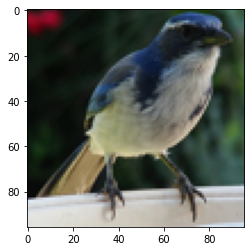

In [3]:
# convert to tensor format
# convert data to tensor format
x_train, y_train, x_valid, y_valid = map(torch.tensor, (train_x, train_y, valid_x, valid_y))

# batch size
bs = 50

# pytorch DataLoader implementation 
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

print(y_train[3])

pyplot.imshow(x_train[4])

In [4]:
# define model
class STL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
        self.linear_1 = nn.Linear(4096, 256)
        self.linear_2 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, xb):
        xb = xb.view(-1, 3, 96, 96)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv1_1(xb))
        xb = self.maxpool(xb)
        
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv2_1(xb))
        xb = self.maxpool(xb)    
        
        xb = F.relu(self.conv3(xb))
        xb = F.relu(self.conv3_1(xb))
        # feature map
        feature_map = xb.clone()
        
        xb = self.maxpool(xb)
        
        #prob = F.avg_pool2d(xb, 3)
        # sequential
        #print(xb.shape)

        xb = xb.view(-1, 4096)
        xb = F.relu(self.linear_1(xb))
        xb = self.dropout(xb)
        xb = F.relu(self.linear_2(xb))
        
        weight = xb.clone()
        xb = self.dropout(xb)
        prob = xb.view(-1, xb.size(1))
        _, pre_value = torch.topk(prob, 1)
        
        # xb is the feature map
        # prob is the predicated value, used in multicalss cross entropy calculation
        # predicted value
        
        return feature_map, weight, prob, pre_value

# utitiy functions
# loss function
loss_func = F.cross_entropy

# loss batches function for fitting function
def loss_batch(model, loss_func, xb, yb, device, opt=None):
    xb = xb.to(device, dtype=torch.float)
    yb = yb.to(device, dtype=torch.long)
    _, pre, _ , _ = model(xb)
    loss = loss_func(pre, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

# define fit function
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, best_model_path, device):
    val_loss = 10000
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, device, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb, device) for xb, yb in valid_dl]
            )
        val_loss_tmp = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        if val_loss_tmp < val_loss:
            val_loss = val_loss_tmp
            torch.save(model.state_dict(), best_model_path)
        print(epoch, val_loss)

In [5]:
training = False

#check gpu available 
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")

if not training:
    device = torch.device("cpu")

model = STL_CNN().to(device)

#optimizer parameter
lr = 2e-4
decay = 1e-6
momentum = 0.9
opt = optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9, nesterov=True)

epochs = 1
best_model_path = "model/stl_cnn/bestmodel.pth"
if training:
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, best_model_path, device)
else:
    model.load_state_dict(torch.load(best_model_path))

Running on the GPU


In [6]:
# test image prediction
device = torch.device("cpu")
model = STL_CNN().to(device)
model.load_state_dict(torch.load(best_model_path))

def calculate_accuracy(model, x, y):
    correct = 0.0
    total = len(x)
    for image, label in zip(x, y):
        _, _, _, pre = model(image.to(dtype=torch.float).reshape(3, 96, 96))
        pre = pre.detach().numpy().squeeze()
        label = label.detach().numpy().squeeze()
        if pre == label:
            correct += 1
    print('total accuracy {}'.format(float(correct/total)))
    
#calculate_accuracy(model, x_train, y_train)

In [27]:
def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = pyplot.subplots(
        n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

def heatmap(model, image):
    image = image.to(dtype=torch.float).reshape(3, 96, 96)
    feature_map, weight, prob, pre_value = model(image)
    feature_map = feature_map.reshape(256, 11, 11).detach().numpy()
    weight = weight.view(1, weight.shape[1]).detach().numpy().squeeze()
    weight = weight / np.sum(weight)

    heatmap = np.zeros((96, 96))
    for i, w in enumerate(weight):
        resized = cv.resize(feature_map[i, :, :], (96, 96), interpolation=cv.INTER_CUBIC)
        heatmap += w * resized 
    return heatmap

def generate_plot_pic(model, start, end):
    heatmaplist = [heatmap(model, tmp) for tmp in x_train[start:end]]
    origiallist = x_train[start:end]
    image = []
    for tmp1, tmp2 in zip(heatmaplist, origiallist):
        image.append(tmp2)
        
        #tmp1 = (tmp1*255).astype(np.uint8)
        #tmp1 = cv.applyColorMap(tmp1, cv.COLORMAP_AUTUMN)
        #tmp2 = tmp2.detach().numpy()
        #tmp1 = cv.addWeighted(tmp1, 0.3, tmp2, 0.7, 0.1)
        image.append(tmp1)
    
    title = y_train[start: end].detach().numpy()
    
    titlelist = []
    for tmp in title:
        tmp = str(tmp)
        titlelist.append(tmp + ' origin')
        titlelist.append(tmp + ' heatmap')
        
    cmaplist = ['gray', 'viridis'] * (end - start)
    
    
    return image, titlelist, cmaplist

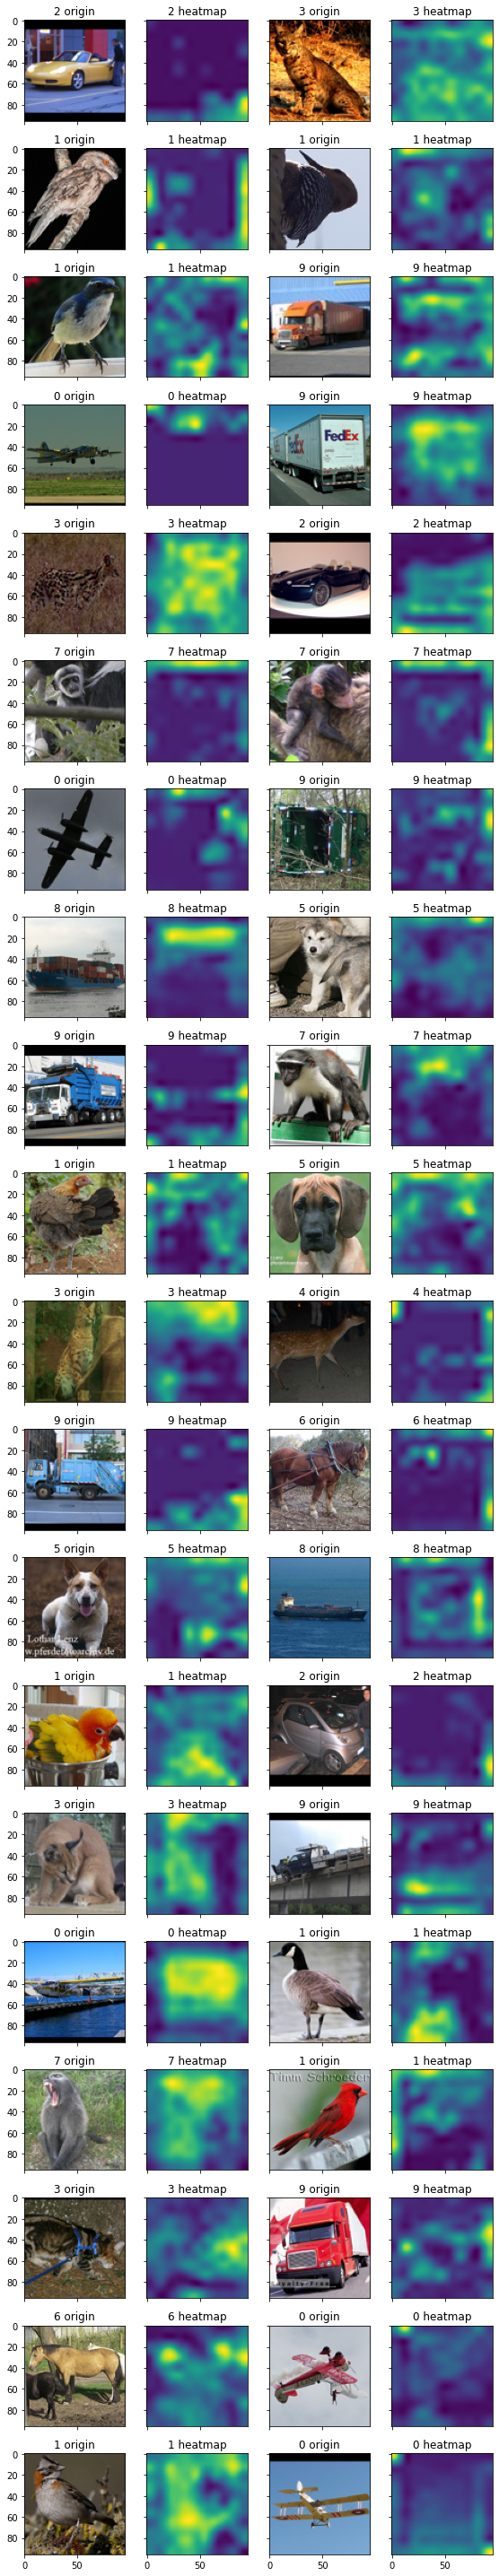

In [29]:
image, title, cmaplist = generate_plot_pic(model, 0, 40)
plot_multiple(image, title, cmaplist, 4)
pyplot.show()